## MNIST CNN (Keras + Tensorflow)

Comparison of Deep Shapley propagation with
- Gradient * Input
- Integrated Gradients
- DeepLIFT (Rescale and RevealCancel)
- Simple occlusion

### Get started
Assuming you have Keras > 2.2 and Tensorflow > 1.10, you will need the following libraries for comparison
- Install **DeepExplain**
https://github.com/marcoancona/DeepExplain
- Install **DeepLIFT**
https://github.com/kundajelab/deeplift
- Install **SHAP**
https://github.com/slundberg/shap

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os, pickle
sys.path.insert(0, os.path.abspath('../..'))
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 


import keras
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D
from keras import regularizers
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy
print ("Using TF:", tf.__version__)
print ("Using Keras:", keras.__version__)

# Import DASP
from dasp import DASP

#Import DeepLift
# Installation instructions: https://github.com/kundajelab/deeplift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

# Import Deep Explain (for Grad * Input, Integrated Gradients and Occlusion implementations)
# Installation instructions: https://github.com/marcoancona/DeepExplain
from deepexplain.tensorflow import DeepExplain

def GetSpacedElements(array, numElems = 4):
    return [x[len(x)//2] for x in np.array_split(np.array(array), numElems)]

Using TensorFlow backend.


Using TF: 1.10.1
Using Keras: 2.2.0


In [3]:
# Build and train a network.

SKIP_TRAIN = True
saved_model_file = '.model_cnn.h5'
saved_model_weights_file = '.model_cnn_w.h5'

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# resize (optional)
x_train = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_train])
x_test = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_test])


x_train = x_train.reshape(-1, img_rows,img_cols,1)
x_test = x_test.reshape(-1, img_rows,img_cols,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# LeNet-5
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5),activation='relu',input_shape=x_train.shape[1:], name='conv_1'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu', name='conv_2'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu', name='dense_1'))
model.add(Dense(84, activation='relu', name='dense_2'))
model.add(Dense(num_classes, name='dense_3'))
model.add(Activation('softmax'))
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

if SKIP_TRAIN is True:
    model = load_model(saved_model_file)
else:  
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    model.save_weights(saved_model_weights_file)

model.summary()   
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_2 (Dense)              (None, 8

### Define a subset of the test set to generate explanations for

In [4]:
xs = x_test[0:2]
ys = y_test[0:2]

a_gradin = np.zeros_like(xs)
a_intgrad = np.zeros_like(xs)
a_res = np.zeros_like(xs)
a_rc = np.zeros_like(xs)
a_occlusion = np.zeros_like(xs)
a_shap = np.zeros_like(xs)
a_sampling = np.zeros_like(xs)

### Use Deep Shapley propagation to compute approximate Shapley Values.
Notice that this requires to convert our original model into a propababilistic one. We provide probabilistic layers for this.
Also, this will require O(c*n) evaluations of the probabilistic network, where n is the number of input features and c is the number of coalition sizes to be tested (ideally c = n)

In [5]:
dasp = DASP(Model(model.inputs, model.layers[-2].output))
shapley = dasp.run(xs, 16)
a_shap = np.array([shapley[i, c, :] for i, c in enumerate(np.argmax(ys, 1))])
print (a_shap.shape)

[(None, 28, 28, 1), (None, 28, 28, 1), (None, 1)]
Hello
relu
Tensor("conv_1_2/add_3:0", shape=(?, 24, 24, 6), dtype=float32)
Tensor("conv_1_2/stack:0", shape=(?, 24, 24, 6, 4), dtype=float32)
Tensor("input_4:0", shape=(?, 28, 28, 1, 2), dtype=float32)
Tensor("input_4:0", shape=(?, 28, 28, 1, 2), dtype=float32)
Tensor("max_pooling2d_1_2/stack_1:0", shape=(?, 12, 12, 6, 2), dtype=float32)
Tensor("max_pooling2d_1_2/stack_1:0", shape=(?, 12, 12, 6, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1, 2)      0         
_________________________________________________________________
conv_1 (LPConv2D)            (None, 24, 24, 6, 2)      156       
_________________________________________________________________
max_pooling2d_1 (LPMaxPoolin (None, 12, 12, 6, 2)      0         
_________________________________________________________________
conv

In [6]:
print (a_shap[0])

[[[-1.46774575e-04]
  [-2.40888447e-04]
  [ 6.76140189e-07]
  [ 7.55796209e-04]
  [ 1.00024045e-03]
  [ 6.61063939e-04]
  [ 2.19683163e-03]
  [ 3.29644233e-03]
  [ 4.76240553e-03]
  [ 7.53545016e-03]
  [ 9.21867974e-03]
  [ 8.90485756e-03]
  [ 8.67805257e-03]
  [ 5.02756797e-03]
  [ 2.16335244e-03]
  [ 2.78744847e-05]
  [-3.52517702e-03]
  [-5.11980429e-03]
  [-5.81362285e-03]
  [-1.03403386e-02]
  [-1.38507560e-02]
  [-1.54152717e-02]
  [-1.72366370e-02]
  [-1.29262712e-02]
  [-1.00640897e-02]
  [-5.41547313e-03]
  [-2.29628012e-03]
  [-1.39419176e-03]]

 [[ 2.47877091e-04]
  [ 9.36537981e-05]
  [-5.38004562e-04]
  [-3.33674252e-04]
  [-1.81170180e-04]
  [ 2.21338123e-05]
  [ 1.70035101e-03]
  [ 2.91231833e-03]
  [ 5.91203012e-03]
  [ 9.11490619e-03]
  [ 1.13906730e-02]
  [ 1.06130186e-02]
  [ 7.96205178e-03]
  [ 4.61456925e-03]
  [-1.75790302e-03]
  [-2.46477686e-03]
  [-5.17526455e-03]
  [-8.63302499e-03]
  [-1.21757761e-02]
  [-1.50675662e-02]
  [-1.64022446e-02]
  [-1.65273193e-02

In [6]:
# Load or...
r = pickle.load( open( "data/mnist_cnn_dasps.pkl", "rb" ) )



dasps = []
kns = [1, 2, 4, 8, 16, 32, 64, 128, 256]
for xn in kns:
    Ks = GetSpacedElements(range(r.shape[1]), xn)
    print (Ks)
    s = r[:,Ks, :].mean(1).reshape(-1,28,28)
    dasps.append((xn, s))
a_shap = dasps[-1][1]

# with open('data/mnist_cnn_dasps.pkl', 'wb') as f:
#     pickle.dump(r, f)

[131]
[65, 196]
[33, 99, 164, 229]
[16, 49, 82, 115, 148, 181, 214, 246]
[8, 25, 42, 59, 76, 93, 110, 126, 142, 158, 174, 190, 206, 222, 238, 254]
[4, 13, 22, 31, 40, 49, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146, 154, 162, 170, 178, 186, 194, 202, 210, 218, 226, 234, 242, 250, 258]
[2, 7, 12, 17, 22, 27, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260]
[1, 4, 7, 10, 13, 16, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189

In [16]:
print(np.isnan(a_shap).any())

True


In [54]:
# Comparison first hidden layer distributions
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.mlab as mlab

ks = GetSpacedElements(range(784), 8)


histograms = []
stats_mu = []
stats_std = []
units = []

for i, k in enumerate(ks):
    row = i // 4
    col = i % 4

    idx = 1
    unit_idx = 343 #np.random.randint(2000)
    units.append(unit_idx)

    testmodel = Sequential()
    testmodel.add(Conv2D(6, kernel_size=(5, 5),activation='linear',input_shape=x_train.shape[1:], name='conv_1'))
    testmodel.load_weights(saved_model_weights_file, by_name=True)


    # Create an equivalent probabilistic model.
    probInputTest = Input(shape=xs.shape[1:])
    playerMaskTest = Input(shape=xs.shape[1:])
    coalitionSizeTest = Input(shape=(1,))

    y = ProbConv2DInput(6, (5, 5), activation='linear', name='conv_1')([probInputTest, playerMaskTest, coalitionSizeTest])
    probModelTest = Model(inputs=[probInputTest, playerMaskTest, coalitionSizeTest], outputs=y)
    probModelTest.load_weights(saved_model_weights_file, by_name=True)

    results = []
    for i in range(10000):
        x = xs[idx:idx+1].reshape(1, 28*28)
        p = np.random.permutation(28*28)
        m = np.zeros_like(x)
        m[0, p[:k]] = 1
        y = testmodel.predict((x*m).reshape(1, 28, 28, 1))
        results.append(y.flatten()[unit_idx])
    histograms.append(results)


    # Workaround: Keras does not seem to support scalar inputs
    _k = np.array([[k]]*len(x))
    mask = np.ones_like(x).reshape(1, 28, 28, 1)
    mask[0, 0, 0] = 0
    Y = probModelTest.predict([x.reshape(1, 28, 28, 1), mask, _k])
    Y = Y.reshape(-1, 4)[unit_idx]
    mu, sigma = Y[0], Y[1]**0.5
    stats_mu.append(mu)
    stats_std.append(sigma)
    print (mu, sigma**2)
    print ("Stats")
    print (np.mean(results), np.var(results))

[(None, 28, 28, 1), (None, 28, 28, 1), (None, 1)]
Hello
linear
Tensor("conv_1_197/BiasAdd:0", shape=(?, 24, 24, 6), dtype=float32)
-0.07568297 0.04113425314426422
Stats
-0.07563153 0.0482892
[(None, 28, 28, 1), (None, 28, 28, 1), (None, 1)]
Hello
linear
Tensor("conv_1_199/BiasAdd:0", shape=(?, 24, 24, 6), dtype=float32)
-0.32828486 0.10694906115531921
Stats
-0.3268968 0.12500486
[(None, 28, 28, 1), (None, 28, 28, 1), (None, 1)]
Hello
linear
Tensor("conv_1_201/BiasAdd:0", shape=(?, 24, 24, 6), dtype=float32)
-0.5808867 0.1508255898952484
Stats
-0.57770807 0.17970933
[(None, 28, 28, 1), (None, 28, 28, 1), (None, 1)]
Hello
linear
Tensor("conv_1_203/BiasAdd:0", shape=(?, 24, 24, 6), dtype=float32)
-0.83348864 0.17276385426521298
Stats
-0.84085625 0.20629936
[(None, 28, 28, 1), (None, 28, 28, 1), (None, 1)]
Hello
linear
Tensor("conv_1_205/BiasAdd:0", shape=(?, 24, 24, 6), dtype=float32)
-1.0860906 0.17276386916637418
Stats
-1.0854514 0.2061358
[(None, 28, 28, 1), (None, 28, 28, 1), (None, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  from ipykernel import kernelapp as app


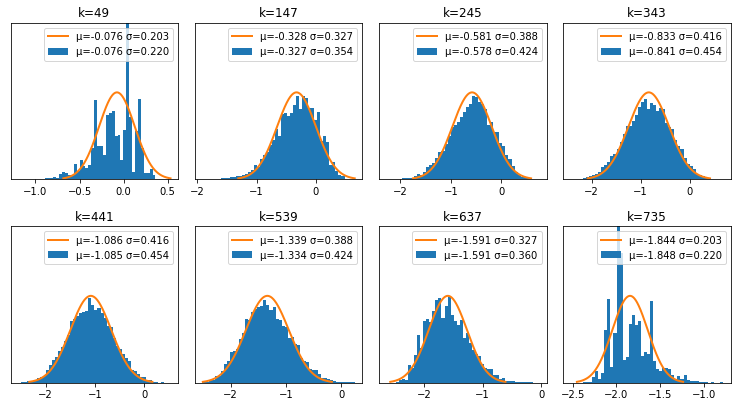

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
plt.rc('text', usetex=False)
for i, (samples, mu, sigma, unit_idx, k) in enumerate(zip(histograms, stats_mu, stats_std, units, ks)):
    row = i // 4
    col = i % 4
    ax = axes[row][col]
    
    mu1, s1 = np.mean(samples), np.std(samples)
    ax.hist(samples, bins=50, density=True, label='μ=%.3f σ=%.3f' % (mu1, s1))
    ax.get_yaxis().set_visible(False)
    #ax.set_title('Unit %d (k=%d)' % (unit_idx, k))
    ax.set_title('k=%d' % (k))

    _x = np.linspace(mu - 3*sigma, mu + 3*sigma, 400, )
    pdf = mlab.normpdf(_x, mu, sigma)
    ax.plot(_x, pdf, linewidth=2, label='μ=%.3f σ=%.3f' % (mu, sigma))
    ax.set_ylim(0, 1.8*np.max(pdf))
    ax.legend()
    
fig.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
plt.show()
fig.savefig('results/inputdistribution2_mnist.pdf', bbox_inches = "tight")

AttributeError: 'numpy.ndarray' object has no attribute 'show'

### Use DeepExplain framework to compute attributions using Gradient * Input, Integrated Gradients and Occlusion
Occlusion is performed by replacing one pixel at the time with a zero value and measuring the difference in the target output caused by such occlusion.

In [7]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    a_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    #intgrads = [(k, de.explain('intgrad', target_tensor * ys, input_tensor, xs, steps=k)) for k in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 2*4096]]
    a_occlusion = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print ("Done")

DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "occlusion" explanation method (6)
Model with multiple inputs:  False
Input shape: (28, 28, 1); window_shape (1, 1, 1); step 1
Done
CPU times: user 1.32 s, sys: 76 ms, total: 1.39 s
Wall time: 1.12 s


### Use DeepLIFT framework to compute attributions according to both Rescale and RevealCancel methods

In [8]:
%%time
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

    
    
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_res = np.array([np.array(rescale_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

nonlinear_mxts_mode is set to: RevealCancel
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
CPU times: user 3.74 s, sys: 36 ms, total: 3.78 s
Wall time: 3.8 s


In [ ]:
# import shap

# # select a set of background examples to take an expectation over
# background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# # explain predictions of the model on four images
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-2].output), background)
# shap_values = e.shap_values(xs)
# #shap.image_plot(shap_values, -xs)
# a_shaplud = [shap_values[idx][i] for i, idx in enumerate(np.argmax(ys, 1))]

In [9]:
%%time
# from utils.shapley_sampling import run_shapley_sampling
# samplings_new = []
# def callback(snapshot):
#     print (snapshot[0])
#     #samplings_new.append(snapshot)

# def run_sampling(runs):
#     return run_shapley_sampling(fModel, xs, ys, runs=runs, feat_dims=[1,2], callback=callback)
# run_sampling(2**5)

# with open('data/mnist_cnn_sampling.pkl', 'wb') as f:
#     pickle.dump(a_sampling, f)
# with open('data/mnist_cnn_samplings.pkl', 'wb') as f:
#     pickle.dump(samplings, f)
    
a_sampling = pickle.load( open( "data/mnist_cnn_sampling.pkl", "rb" ) )
samplings = pickle.load( open( "data/mnist_cnn_samplings.pkl", "rb" ) )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.18 ms


In [9]:
attributions = [
    ('Integrated\nGradients',      a_intgrad.reshape(xs.shape)), 
    ('DeepLIFT\n(Rescale)',        a_res.reshape(xs.shape)), 
    ('DeepLIFT\n(RevCancel)',      a_rc.reshape(xs.shape)), 
    ('Occlusion',                  a_occlusion.reshape(xs.shape)), 
    ('DASP (ours)',                a_shap.reshape(xs.shape)), 
    ('Sampling\n(Ground Truth)',                   a_sampling.reshape(xs.shape))
]
for a in attributions:
    print (a[1].shape)

# attributions = pickle.load( open( "data/mnist_cnn_attributions.pkl", "rb" ) )

(2, 28, 28, 1)
(2, 28, 28, 1)
(2, 28, 28, 1)
(2, 28, 28, 1)
(2, 28, 28, 1)
(2, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


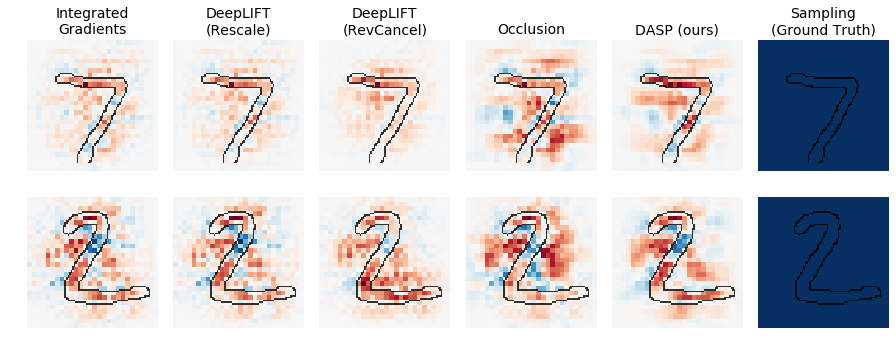

In [10]:
# Plot attributions
%matplotlib inline
from utils.utils import plot_attribution_maps

# Plot all
plot_attribution_maps("mnist_cnn", xs, [x[1] for x in attributions], [x[0] for x in attributions], idxs=[0,1])

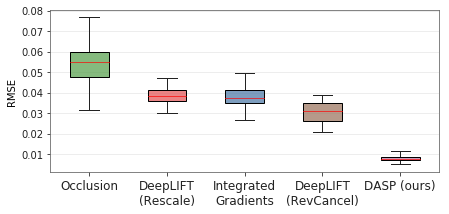

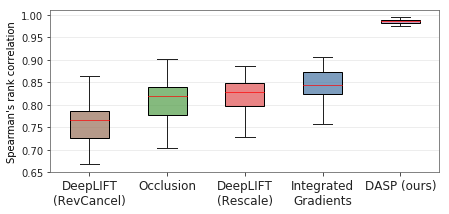

In [13]:
from utils.utils import plot_mse_comparison, plot_kendall_comparison

plot_mse_comparison("mnist_cnn", [x[1] for x in attributions], [x[0] for x in attributions], gt_idx=-1)
plot_kendall_comparison("mnist_cnn", [x[1] for x in attributions], [x[0] for x in attributions], gt_idx=-1)

Running robustness test...


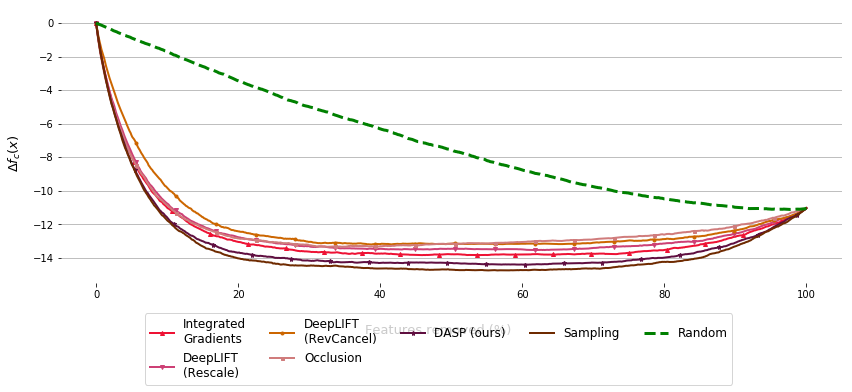

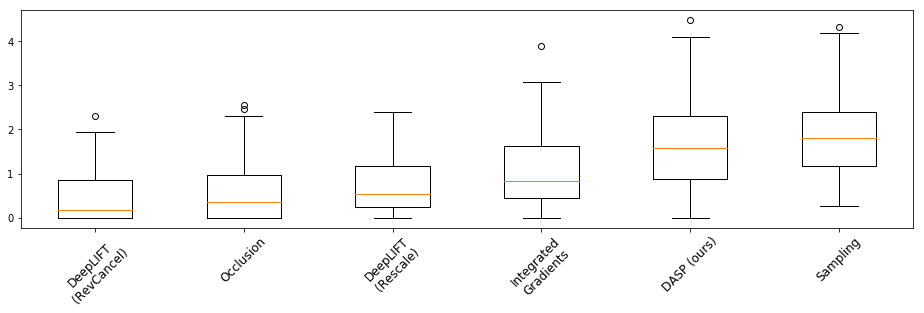

In [14]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from utils.accuracy_robustness import run_robustness_test
init_notebook_mode(connected=True)

run_robustness_test(fModel, xs, ys,  [x[1] for x in attributions], [x[0] for x in attributions], 'mnist_cnn', 1,
                        result_path='.', mode='prediction', reduce_dim=None)

### Run Deep Shapley with different values of kn and measure how fast it converges

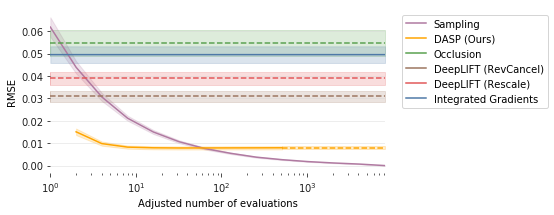

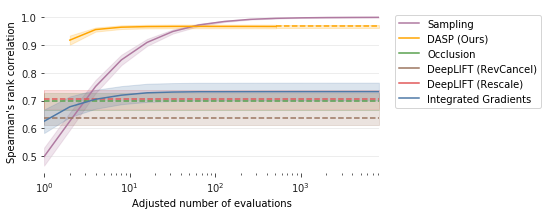

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]


In [30]:
from utils.convergence_plot import convergence_comparison_rmse, convergence_comparison_corr
_samplings_y = [x[1] for x in samplings]
_samplings_x = [x[0] for x in samplings]
_dasps_y = [x[1] for x in dasps]
_dasps_x = [x[0] for x in dasps]
_intgrad_y = [x[1]*(1/(28*28)) for x in intgrads]
_intgrad_x = [x[0] for x in intgrads]
ticks = [_samplings_x, [2*x for x in _dasps_x], [1], [1], [1], _intgrad_x]
names = ['Sampling', 'DASP (Ours)', 'Occlusion', 'DeepLIFT (RevCancel)', 'DeepLIFT (Rescale)', 'Integrated Gradients']
data = [_samplings_y, _dasps_y, [a_occlusion], [a_rc], [a_res], _intgrad_y]

# ticks = [[2*x for x in _dasps_x], [1], [1], [1], _intgrad_x]
# names = [ 'DASP (Ours)', 'Occlusion', 'DeepLIFT (RevCancel)', 'DeepLIFT (Rescale)', 'Integrated Gradients']
# data = [ _dasps_y, [a_occlusion], [a_rc], [a_res], _intgrad_y]

convergence_comparison_rmse('mnist_cnn', data, names, ticks, a_sampling)
convergence_comparison_corr('mnist_cnn', data, names, ticks, a_sampling)
print (_samplings_x)